In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
df = pd.read_csv("../data/clean_enc.csv")
df = df[['male', 'DASA', 'DVM', 'ATTENDS LECTURES', 'LITE',  'GRAMS / MONTH', 'GPL']]
in_features = len(list(df.columns)) - 1
df

,male,DASA,DVM,ATTENDS LECTURES,LITE,GRAMS / MONTH,GPL
0,1.0,0.0,0.0,0.0,1.0,0.447005,0.0
1,0.0,1.0,0.0,0.0,0.0,0.004608,1.0
2,0.0,0.0,0.0,0.0,0.0,0.013825,1.0
3,0.0,1.0,0.0,0.0,0.0,0.004608,1.0
4,1.0,0.0,0.0,0.0,1.0,0.769585,0.0
...,...,...,...,...,...,...,...
1085,1.0,0.0,0.0,0.0,0.0,0.345622,0.0
1086,0.0,0.0,0.0,0.0,0.0,0.013825,1.0
1087,0.0,0.0,0.0,1.0,1.0,0.483871,0.0
1088,1.0,1.0,0.0,0.0,0.0,0.788018,0.0


In [3]:
full = torch.Tensor(df.values)
full.shape

torch.Size([1090, 7])

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from torch.utils.data import TensorDataset, random_split

test_split = math.floor(0.2*len(full))
train_split = len(full) - test_split

full_dataset = TensorDataset(full)
# torch.manual_seed(42)
train_set, test_set = random_split(full_dataset, [train_split, test_split])

# Don't wan't to deal with dataloaders
train_set = train_set[:][0]
test_set = test_set[:][0]

X_train, y_train = train_set[:, :-1], train_set[:, -1]
X_test, y_test = test_set[:, :-1], test_set[:, -1]

X_test[1]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0323])

In [6]:
hidden_nodes = 2

class ModelV3_2(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear_1 = nn.Linear(in_features=in_features, out_features=hidden_nodes)
        self.linear_2 = nn.Linear(in_features=hidden_nodes, out_features=hidden_nodes)
        self.linear_3 = nn.Linear(in_features=hidden_nodes, out_features=hidden_nodes)
        self.linear_4 = nn.Linear(in_features=hidden_nodes, out_features=1)
    
    def forward(self, x):
        return self.linear_4(self.linear_3(self.linear_2(self.linear_1(x))))
# torch.manual_seed(42)
model_3_2 = ModelV3_2()
model_3_2

ModelV3_2(
  (linear_1): Linear(in_features=6, out_features=2, bias=True)
  (linear_2): Linear(in_features=2, out_features=2, bias=True)
  (linear_3): Linear(in_features=2, out_features=2, bias=True)
  (linear_4): Linear(in_features=2, out_features=1, bias=True)
)

In [7]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3_2.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=250, gamma=0.1)

def acc_fn(pred_labels, true_labels):
    return ((torch.eq(pred_labels, true_labels).sum())/len(true_labels))*100

Epoch: 0 | Train loss: 0.7551060318946838 | Train Accuracy: 38.188072204589844 | Test loss: 0.7340390086174011 | Test Accuracy: 41.74312210083008
Epoch: 50 | Train loss: 0.17785030603408813 | Train Accuracy: 93.9220199584961 | Test loss: 0.21494030952453613 | Test Accuracy: 93.1192626953125
Epoch: 100 | Train loss: 0.08354724943637848 | Train Accuracy: 96.78899383544922 | Test loss: 0.07681306451559067 | Test Accuracy: 96.78899383544922
Epoch: 150 | Train loss: 0.07401806861162186 | Train Accuracy: 97.59174346923828 | Test loss: 0.06110027804970741 | Test Accuracy: 98.1651382446289
Epoch: 200 | Train loss: 0.07240280508995056 | Train Accuracy: 97.59174346923828 | Test loss: 0.055840183049440384 | Test Accuracy: 98.1651382446289
Epoch: 250 | Train loss: 0.07197517156600952 | Train Accuracy: 97.59174346923828 | Test loss: 0.053578831255435944 | Test Accuracy: 98.62385559082031
Epoch: 299 | Train loss: 0.07195662707090378 | Train Accuracy: 97.59174346923828 | Test loss: 0.0534486733376979

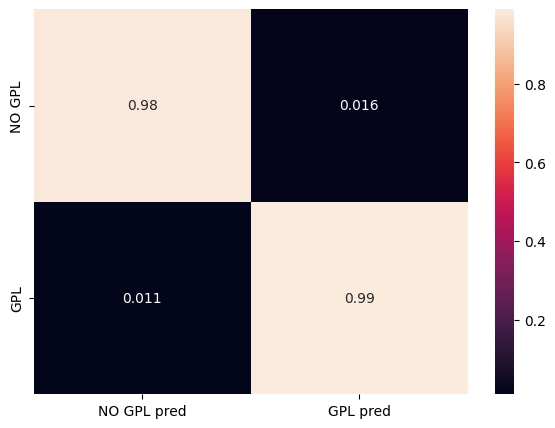

In [8]:
from torch.utils.tensorboard import SummaryWriter
from random import randrange
from sklearn.metrics import confusion_matrix

writer = SummaryWriter()

results = {
    "train_loss": [],
    "train_acc": [], 
    "test_loss": [],
    "test_acc": []
}

model_3_2 = model_3_2.to(device)
X_train = X_train.to(device)
X_test =  X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

epochs = 300

loss_arr = []
acc_arr = []
test_loss_arr = []
test_acc_arr = []

for epoch in range(epochs):

    model_3_2.train()

    y_logits = model_3_2(X_train).squeeze()
    y_labels = torch.round(torch.sigmoid(y_logits))
    optimizer.zero_grad()
    loss = loss_fn(y_logits, y_train)
    acc = acc_fn(y_labels, y_train)
    loss.backward()
    optimizer.step()
    scheduler.step()

    results["train_loss"].append(loss.item())
    results["train_acc"].append(acc)

    model_3_2.eval()
    with torch.inference_mode():
        test_logits = model_3_2(X_test).squeeze()
        test_labels = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test) 
        test_acc = acc_fn(test_labels, y_test)
        results["test_loss"].append(test_loss.item())
        results["test_acc"].append(test_acc) 
    
    if epoch%50==0 or epoch==(epochs-1):
        print(f"Epoch: {epoch} | Train loss: {loss} | Train Accuracy: {acc} | Test loss: {test_loss} | Test Accuracy: {test_acc}")

    if epoch==(epochs-1):
        cf_matrix = confusion_matrix(y_test, test_labels)  
        print(cf_matrix)
        df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index= ['NO GPL', 'GPL'], columns=['NO GPL pred', 'GPL pred'])   
        plt.figure(figsize=(7,5)) 
        print(df_cm)
        sns.heatmap(df_cm, annot=True)

    writer.add_scalars(main_tag="Loss", tag_scalar_dict={"train_loss": loss, "test_loss": test_loss}, global_step=epoch)
    writer.add_scalars(main_tag="Accuracy", tag_scalar_dict={"train_acc": acc, "test_acc": test_acc}, global_step=epoch)
    writer.add_graph(model=model_3_2, input_to_model= X_test[randrange(test_split)])

writer.close()

model_3_2 = model_3_2.to("cpu")
X_train = X_train.to("cpu")
X_test =  X_test.to("cpu")
y_train = y_train.to("cpu")
y_test = y_test.to("cpu")


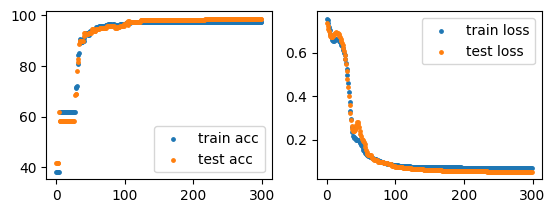

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.scatter(range(epochs),results["train_acc"], s=6, label='train acc')
ax1.scatter(range(epochs), results["test_acc"], s=6,label='test acc')
ax1.legend()

ax2.scatter(range(epochs),results["train_loss"], s=6, label='train loss')
ax2.scatter(range(epochs), results["test_loss"], s=6,label='test loss')
ax2.legend()

plt.show()

In [10]:
from pathlib import Path

MODEL_PATH = Path("../models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model_3_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_3_2.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: ..\models\model_3_2.pth


In [11]:
loaded_model_3 = ModelV3_2()
loaded_model_3.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_3

ModelV3_2(
  (linear_1): Linear(in_features=6, out_features=2, bias=True)
  (linear_2): Linear(in_features=2, out_features=2, bias=True)
  (linear_3): Linear(in_features=2, out_features=2, bias=True)
  (linear_4): Linear(in_features=2, out_features=1, bias=True)
)